In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm


import os
import re


os.chdir("/home/s2113174/Projects-1")

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$\frac{du}{dt} - cos(2 \alpha \pi t)=0$$

with solution 
$$ u(t) =  \frac{sin ( 2 \pi t )}{2 \alpha \pi} + 1$$

## The Problem consist in infering $ \alpha $

Text(0, 0.5, 'Observations')

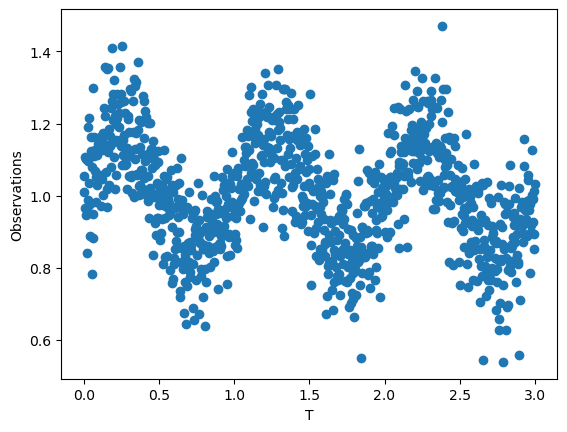

In [2]:
ns = 3
t= np.linspace(0,ns,1000)
mean, std = 0,0.1

Exact = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [3]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [4]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = u_t - torch.cos(pr* 2*torch.pi *t)
    return f

In [5]:
DNN.DE = DE

In [6]:
def sample_ic(size):
    return np.zeros(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return min + np.random.rand(size)*max

In [7]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic, t, param = sample_ic(size),samples_space(size,maxl),samples_param(minp,maxp,size)

    ic, t, param = torch.tensor(ic).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

    ic, t, param = Variable(ic,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,f_pred = pinn(torch.cat([ic, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_f = loss(ic_pred,torch.ones_like(t)),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [8]:
# Number of observations
epochs = 150
nobs = 2000
lr = 0.01

min_param , max_param = 0, 10

space = 3

layers = [2] + 6*[50] + [1]

In [9]:
model = DNN(layers)

In [10]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [11]:
train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

# model.load_state_dict(torch.load("Param_model.pt"))
# model.eval()

Starting Training
Iter 0, Loss: 1.51485e+00, Loss_ic: 1.02684e+00, Loss_f: 4.88008e-01
Iter 0, Loss: 1.51406e+00, Loss_ic: 1.02605e+00, Loss_f: 4.88008e-01
Iter 0, Loss: 1.50697e+00, Loss_ic: 1.01896e+00, Loss_f: 4.88007e-01
Iter 0, Loss: 1.47188e+00, Loss_ic: 9.83872e-01, Loss_f: 4.88004e-01
Iter 0, Loss: 1.12920e+00, Loss_ic: 6.41235e-01, Loss_f: 4.87968e-01
Iter 0, Loss: 1.11307e+00, Loss_ic: 6.25095e-01, Loss_f: 4.87972e-01
Iter 0, Loss: 9.74108e-01, Loss_ic: 4.86103e-01, Loss_f: 4.88005e-01


Iter 0, Loss: 4.90555e-01, Loss_ic: 2.13847e-03, Loss_f: 4.88416e-01
Iter 0, Loss: 4.90526e-01, Loss_ic: 2.11072e-03, Loss_f: 4.88415e-01
Iter 0, Loss: 4.90286e-01, Loss_ic: 1.88275e-03, Loss_f: 4.88404e-01
Iter 0, Loss: 4.90274e-01, Loss_ic: 1.87083e-03, Loss_f: 4.88403e-01
Iter 0, Loss: 4.90217e-01, Loss_ic: 1.81863e-03, Loss_f: 4.88398e-01
Iter 0, Loss: 4.89753e-01, Loss_ic: 1.40527e-03, Loss_f: 4.88348e-01
Iter 0, Loss: 4.89749e-01, Loss_ic: 1.40205e-03, Loss_f: 4.88347e-01
Iter 0, Loss: 4.89713e-01, Loss_ic: 1.37454e-03, Loss_f: 4.88339e-01
Iter 0, Loss: 4.89500e-01, Loss_ic: 1.24349e-03, Loss_f: 4.88256e-01
Iter 0, Loss: 4.89499e-01, Loss_ic: 1.24299e-03, Loss_f: 4.88256e-01
Iter 0, Loss: 4.89493e-01, Loss_ic: 1.24074e-03, Loss_f: 4.88252e-01
Iter 0, Loss: 4.89463e-01, Loss_ic: 1.22922e-03, Loss_f: 4.88234e-01
Iter 0, Loss: 4.89327e-01, Loss_ic: 1.19096e-03, Loss_f: 4.88136e-01
Iter 0, Loss: 4.89321e-01, Loss_ic: 1.18832e-03, Loss_f: 4.88132e-01
Iter 0, Loss: 4.89287e-01, Loss_ic

KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(),"Param_model.pt")

In [ ]:
def test_set(max_space,obs,param,mean,std):

    t= np.linspace(0,max_space,obs)

    sol = (1/ (param*2*np.pi))*np.sin(param*2*np.pi*t)+1

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

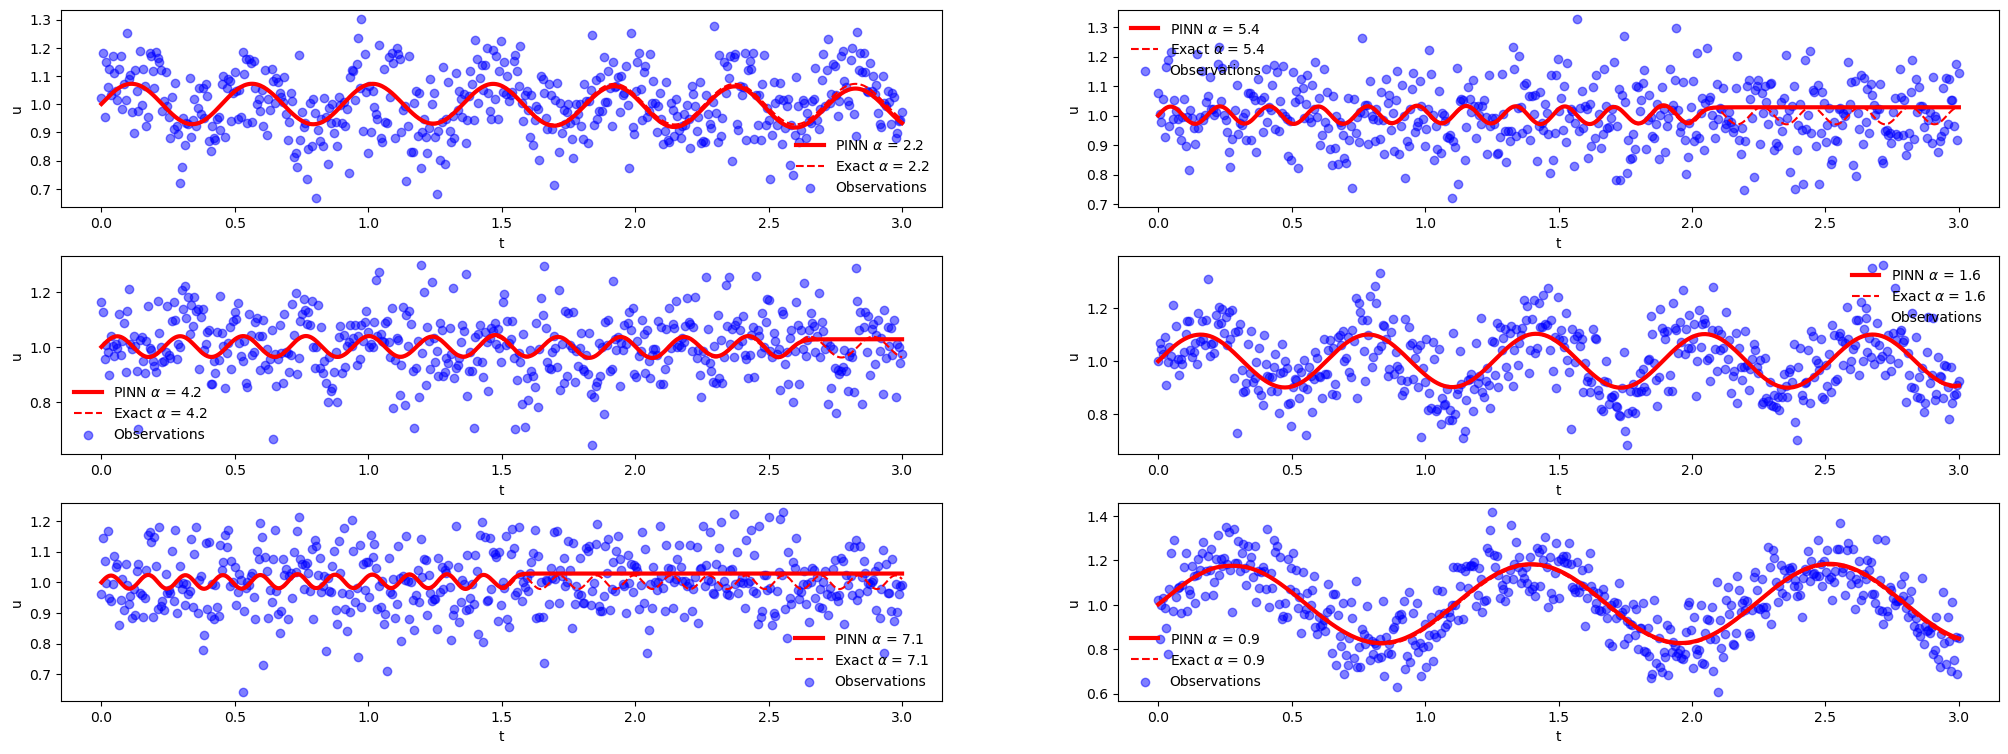

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  samples_param(min_param , max_param,6)


# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,pr in enumerate(param_trained):

    t, noise_sol_test = test_set(ns,500,pr,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))

    u_pred = model(torch.tensor(data_test).float()).detach().cpu().numpy()
    sol = (1/ (pr*2*np.pi))*np.sin(pr*2*np.pi*t)+1


    plt.subplot(8, 2, n + 1)

    plt.plot(t, u_pred, label = fr"PINN $\alpha$ = {pr:.1f}", color = "red",linewidth = '3')

    plt.plot(t, sol, label = fr"Exact $\alpha$ = {pr:.1f}", color = "red",linestyle = '--')
    plt.scatter(t,noise_sol_test, label = "Observations",color= "blue",alpha = 0.5)

    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

## MCMC Step

In [1011]:
def log_prior_alpha(alpha): #function to evaluate prior pdf of given parameters
    return norm.logpdf(alpha,loc = 0,scale = 100)
#
def log_prior_sig(sig): #function to evaluate prior pdf for sigma^2
    return uniform(loc=0.,scale=1).logpdf(sig)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [1012]:
def log_likelihood(surrogate,alpha,t,y_dat,sig = std):
    
    data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

def log_likelihood_ex(alpha,t,y,sig = std):

    surg_exact = (alpha/ (2*np.pi))*np.sin(2*np.pi*t) + 1

    #return np.sum(-np.log(np.sqrt(2* np.pi*sig**2)) - ((y-surg_exact)**2) / (2*sig**2))
    return np.sum(-((y-surg_exact)**2) / (2*sig**2))

In [1013]:
def log_posterior_ex(alpha,t,y):
    return  log_likelihood_ex(alpha,t,y) + log_prior_alpha(alpha)

def log_posterior_nn(model,alpha,t,y):
    return  log_likelihood(model,alpha,t,y) + log_prior_alpha(alpha)

In [1014]:
t, noise_sol_test = test_set(ns,2000,3.5,mean,std)

In [1015]:
alpha_ = np.linspace(3,3.9,200)

alpha_fc,alpha_fc_2,alpha_fc_3 = [],[],[]
alpha_fc_nn,alpha_fc_2_nn,alpha_fc_3_nn = [],[],[]


for alp in alpha_:
    alpha_fc.append(log_posterior_ex(alp,t[:100],noise_sol_test[:100]))
    alpha_fc_nn.append(log_posterior_nn(model,alp,t[:100],noise_sol_test[:100]))
    
    alpha_fc_2.append(log_posterior_ex(alp,t[:500],noise_sol_test[:500]))
    alpha_fc_2_nn.append(log_posterior_nn(model,alp,t[:500],noise_sol_test[:500]))
    
    alpha_fc_3.append(log_posterior_ex(alp,t,noise_sol_test))
    alpha_fc_3_nn.append(log_posterior_nn(model,alp,t,noise_sol_test))

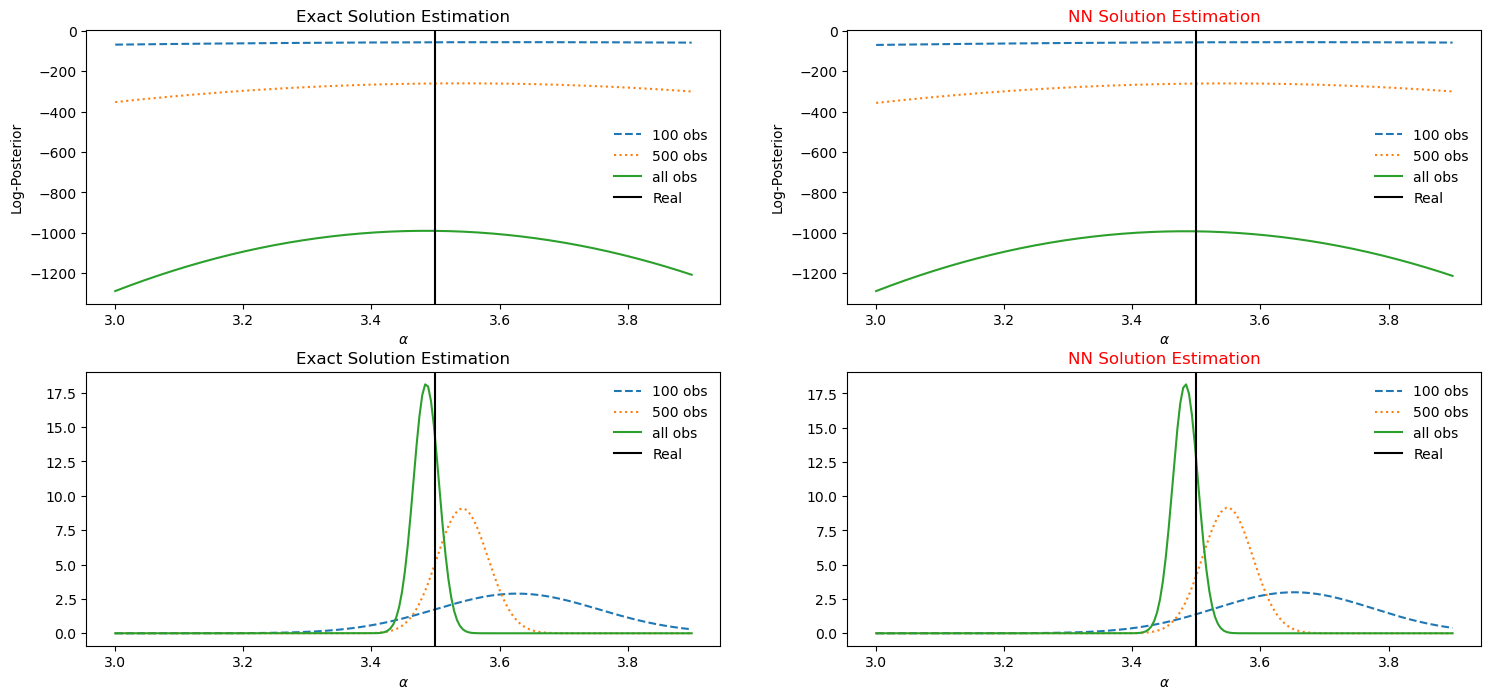

In [1016]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_,alpha_fc ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,alpha_fc_2,linestyle = ':', label = "500 obs")
plt.plot(alpha_,alpha_fc_3, label = "all obs")

plt.axvline(x = 3.5, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 2)
plt.plot(alpha_,alpha_fc_nn ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,alpha_fc_2_nn,linestyle = ':', label = "500 obs")
plt.plot(alpha_,alpha_fc_3_nn, label = "all obs")

plt.axvline(x = 3.5, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 3)
plt.plot(alpha_,200*np.exp(alpha_fc,dtype=np.longdouble)/np.sum(np.exp(alpha_fc,dtype=np.longdouble)) ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_2,dtype=np.longdouble)/np.sum(np.exp(alpha_fc_2,dtype=np.longdouble)),linestyle = ':', label = "500 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_3,dtype=np.longdouble)/np.sum(np.exp(alpha_fc_3,dtype=np.longdouble)), label = "all obs")

plt.axvline(x = 3.5, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 4)
plt.plot(alpha_,200*np.exp(alpha_fc_nn,dtype=np.longdouble)/np.sum(np.exp(alpha_fc_nn,dtype=np.longdouble)) ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_2_nn,dtype=np.longdouble)/np.sum(np.exp(alpha_fc_2_nn,dtype=np.longdouble)),linestyle = ':', label = "500 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_3_nn,dtype=np.longdouble)/np.sum(np.exp(alpha_fc_3_nn,dtype=np.longdouble)), label = "all obs")

plt.axvline(x = 3.5, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)

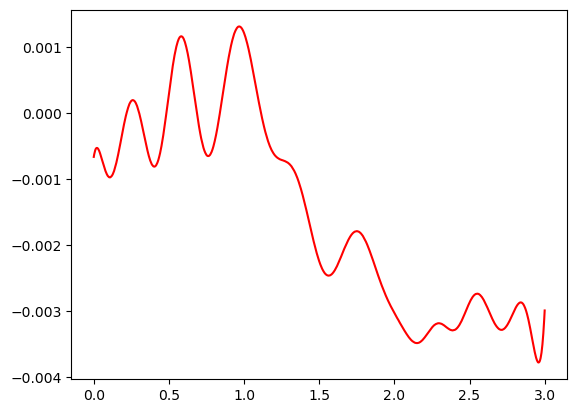

In [21]:
alpha = 2

data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))
surg = model(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)

surg_exact = (alpha/ (2*np.pi))*np.sin(2*np.pi*t) + 1


dif = surg - surg_exact

plt.plot(t,dif, color ="red")


In [22]:
def Metropolis_Hastings(t,y_dat,nChains, exact = False):

    alpha = 5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_ex(alpha,t,y_dat) if exact else log_posterior_nn(model,alpha,t,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat) if exact else log_posterior_nn(model,alpha_proposal,t,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [23]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [24]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

Acceptance Rate: 0.173


In [25]:
alpha_samp_true,dt_tracker_true = Metropolis_Hastings(t,noise_sol_test,100000,exact = True)

/tmp/ipykernel_11631/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.167


Text(0.5, 0, 'Iteration')

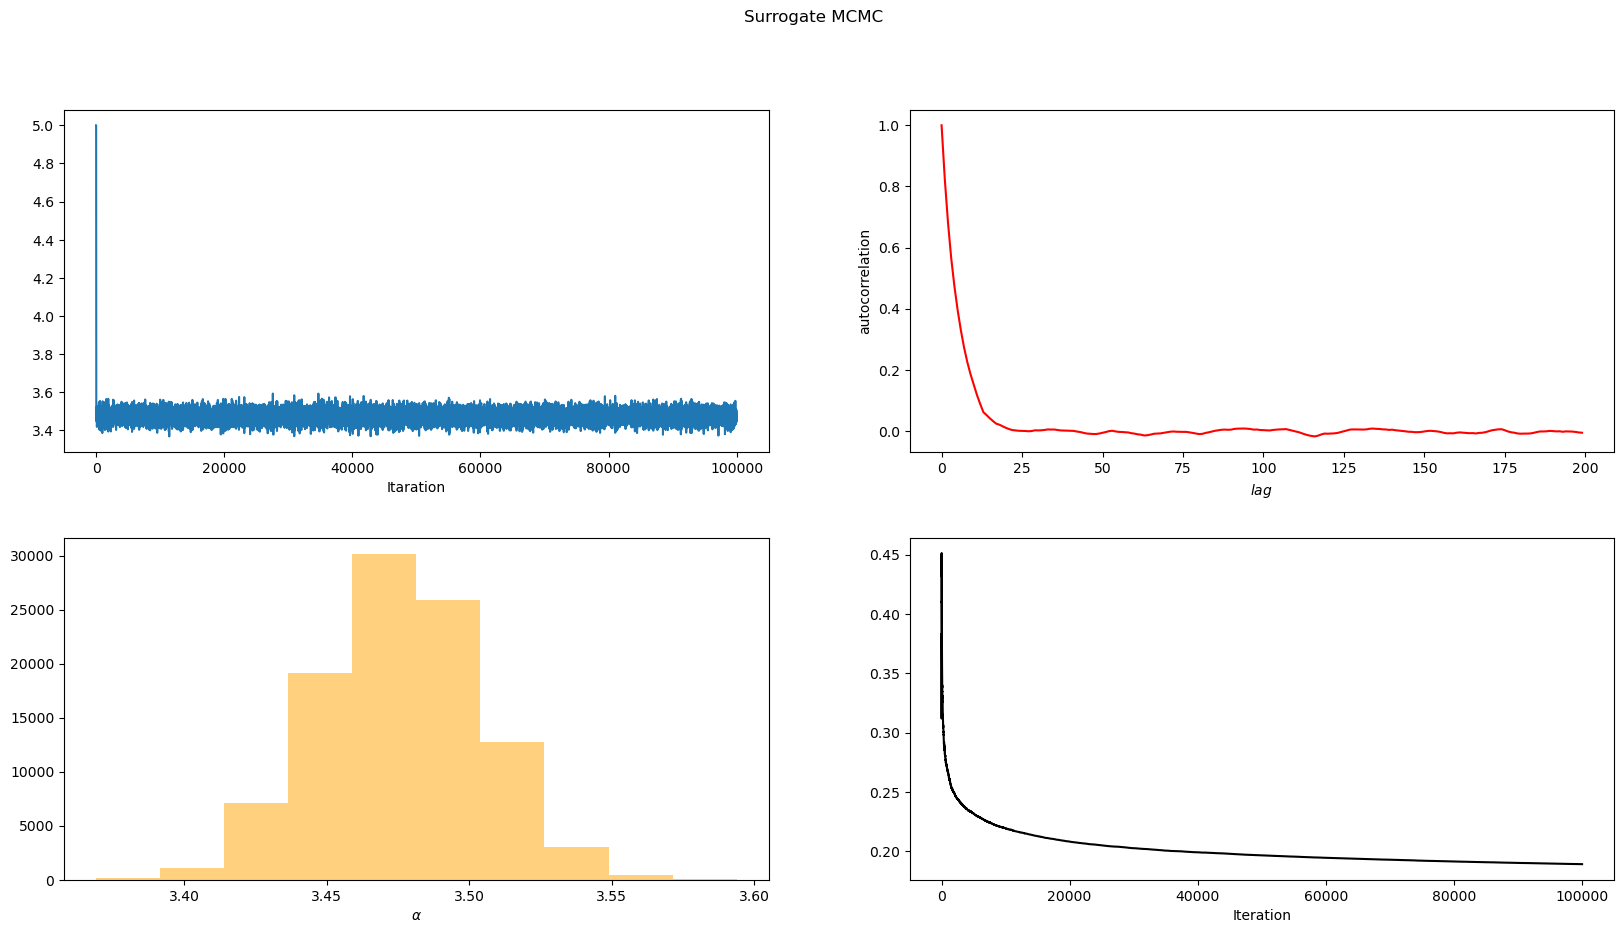

In [26]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp)
plt.xlabel("Itaration")

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
plt.xlabel(r"$\alpha$")

plt.subplot(2, 2, 4)
plt.plot(dt_tracker,color = "black")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

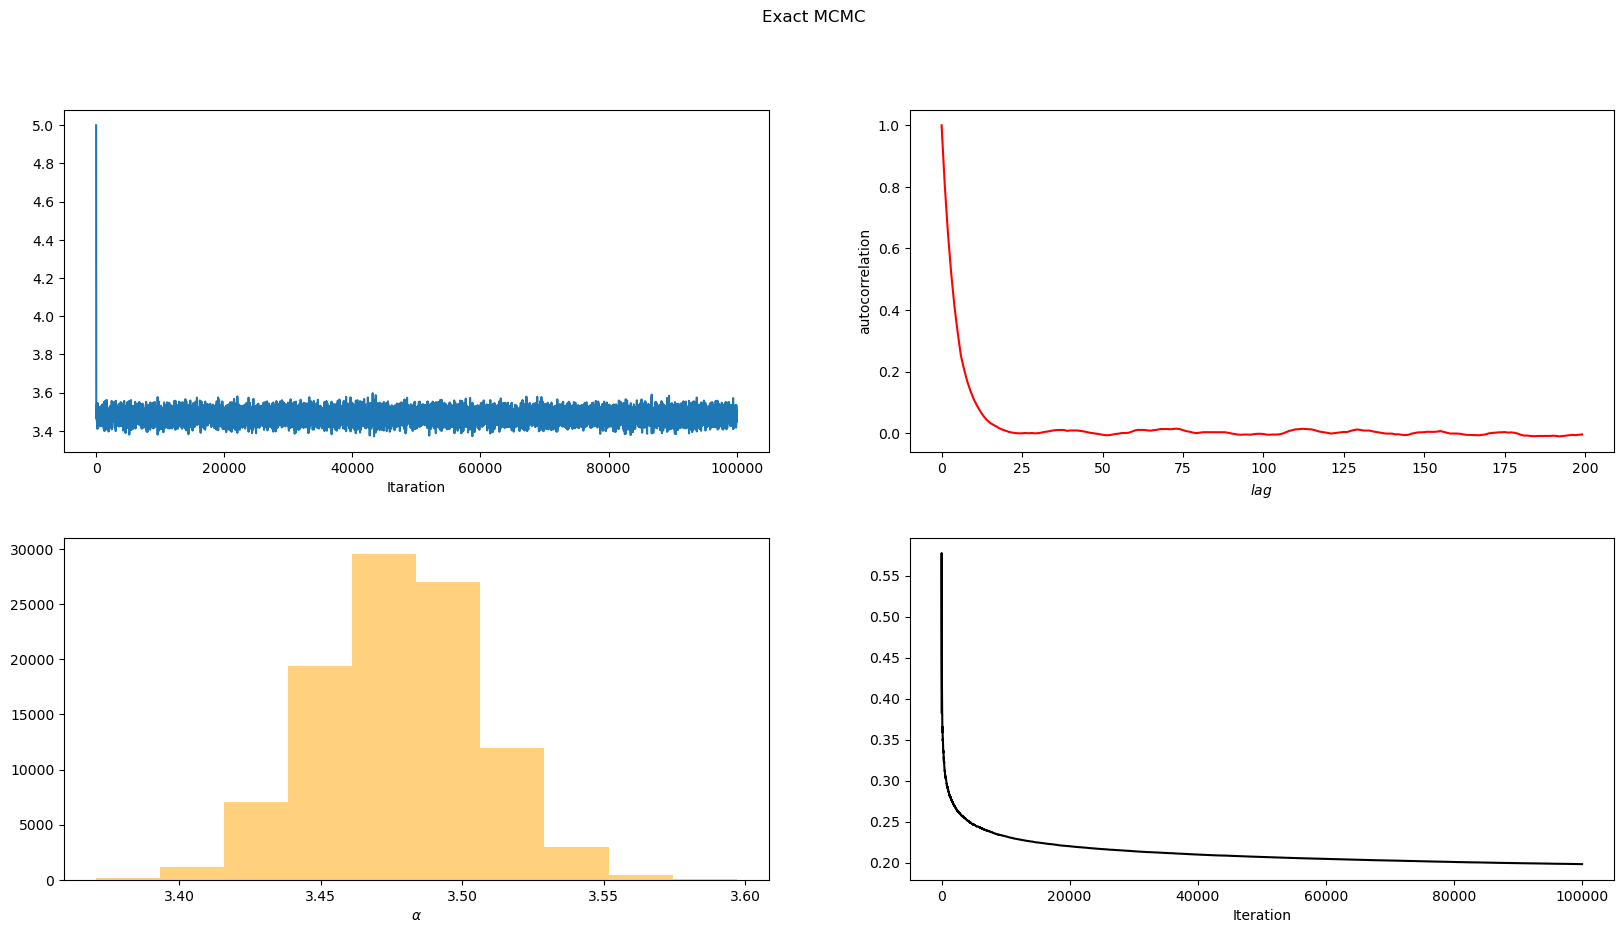

In [27]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Exact MCMC")

plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_true)
plt.xlabel("Itaration")

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_true,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
plt.hist(alpha_samp_true[200:],color = "orange",alpha = 0.5)
plt.xlabel(r"$\alpha$")

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_true,color = "black")
plt.xlabel("Iteration")

In [33]:
from backpack.extensions import DiagGGNExact, DiagGGNMC, KFAC, KFLR, SumGradSquared, BatchGrad
from backpack import backpack, extend, memory_cleanup
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def _get_diag_ggn(model):
    # if self.stochastic:
    #     return torch.cat([p.diag_ggn_mc.data.flatten() for p in self._model.parameters()])
    # else:
    #     return torch.cat([p.diag_ggn_exact.data.flatten() for p in self._model.parameters()])
    return torch.cat([p.diag_ggn_exact.data.flatten() for p in model.parameters()])



def diag(self, X, y, **kwargs):
    context = DiagGGNMC if self.stochastic else DiagGGNExact
    f = self.model(X)
    loss = self.lossfunc(f, y)
    with backpack(context()):
        loss.backward()
    dggn = self._get_diag_ggn()

In [40]:
nobs, min_param , max_param, space = 2000, 0, 10, 3
model_ = extend(model)

ic, t, param = sample_ic(nobs),samples_space(nobs,space),samples_param(min_param , max_param,nobs)

ic, t, param = torch.tensor(ic).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

ic, t, param = Variable(ic,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)
        

ic_pred,f_pred = model_(torch.cat([ic, param], dim=1)),model_.DE(t,param)

loss_u_ic,loss_f = loss(ic_pred,torch.ones_like(t)),loss(f_pred,torch.zeros_like(t))

Loss =  loss_f + loss_u_ic

In [41]:
context = DiagGGNExact


with backpack(context()):
    Loss.backward()

for p in model.parameters():
   p.diag_ggn_exact.data.flatten() 

#dggn = _get_diag_ggn(model)

AttributeError: 'Linear' object has no attribute 'output'